In [1]:
import numpy as np
%matplotlib notebook
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, RateRule, \
                      AssignmentRule, FunctionDefinition
# from gillespy2 import SSACSolver
from gillespy2 import VariableSSACSolver
# from gillespy2 import TauLeapingSolver
# from gillespy2 import TauHybridSolver
# from gillespy2 import ODESolver

# Toggle_Switch

In [2]:
class ToggleSwitch(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Toggle_Switch")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="alpha1", expression="10"))
        self.add_parameter(Parameter(name="alpha2", expression="10"))
        self.add_parameter(Parameter(name="beta", expression="2"))
        self.add_parameter(Parameter(name="gamma", expression="2"))
        self.add_parameter(Parameter(name="mu", expression="1"))

        # Variables
        self.add_species(Species(name="A", initial_value=2, mode="discrete"))
        self.add_species(Species(name="B", initial_value=2, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="cu", reactants={}, products={'A': 1}, propensity_function="alpha1/(1+pow(B, beta))"))
        self.add_reaction(Reaction(name="cv", reactants={}, products={'B': 1}, propensity_function="alpha2/(1+pow(A, gamma))"))
        self.add_reaction(Reaction(name="du", reactants={'A': 1}, products={}, rate=self.listOfParameters["mu"]))
        self.add_reaction(Reaction(name="dv", reactants={'B': 1}, products={}, rate=self.listOfParameters["mu"]))

        # Timespan
        self.timespan(np.arange(0, 250, 1))

In [3]:
model = ToggleSwitch()

# Simulation Parameters

In [4]:
def configure_simulation():
    solver = VariableSSACSolver(model=model)
    kwargs = {
        "solver":solver,
        "number_of_trajectories":100,
        # "seed":None,
        # "tau_tol":0.03,
        # "integrator_options":{'rtol': 0.001, 'atol': 1e-06},
    }
    return kwargs

# Model Exploration

## Define simulator function (using gillespy2 wrapper)

In [5]:
from sciope.utilities.gillespy2 import wrapper
settings = configure_simulation()
simulator = wrapper.get_simulator(gillespy_model=model, run_settings=settings, species_of_interest=['A', 'B'])
expression_array = wrapper.get_parameter_expression_array(model)

## Start local cluster using dask client

In [6]:
from dask.distributed import Client

c = Client()

## Define parameter sampler/design and summary statistics

In [7]:
from sciope.designs import latin_hypercube_sampling
from sciope.utilities.summarystats.auto_tsfresh import SummariesTSFRESH

lhc = latin_hypercube_sampling.LatinHypercube(xmin=expression_array, xmax=expression_array*3)
lhc.generate_array(1000) # creates a LHD of size 1000

# will use default minimal set of features
summary_stats = SummariesTSFRESH()

## Initiate StochMET

In [8]:
from sciope.stochmet.stochmet import StochMET

met = StochMET(simulator, lhc, summary_stats)

## Run parameter sweep

In [9]:
met.compute(n_points=500, chunk_size=10)

## Explore the result

In [10]:
# First lets add some appropiate information about the model and features
met.data.configurations['listOfParameters'] = list(model.listOfParameters.keys())
met.data.configurations['listOfSpecies'] = list(model.listOfSpecies.keys())
met.data.configurations['listOfSummaries'] = met.summaries.features
met.data.configurations['timepoints'] = model.tspan

<IPython.core.display.Javascript object>


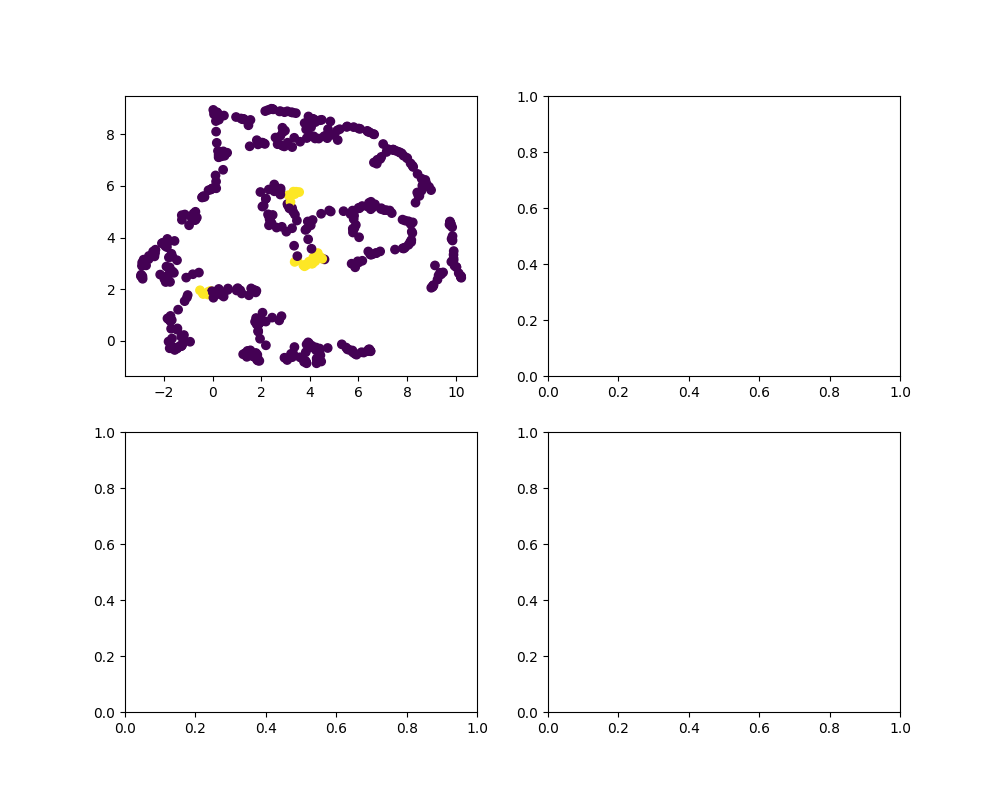

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'A': 0, 'B': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'A': 0, 'B': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,11.441441,11.441441,2.900901,4.838839,2.469469
1,14.564565,14.564565,3.605606,4.286286,2.583584
2,15.725726,12.502503,5.467467,3.473473,1.782783
3,26.576577,23.353353,2.392392,5.011011,1.590591
4,19.629630,22.852853,4.590591,5.943944,2.837838
...,...,...,...,...,...
495,12.842843,12.842843,5.535536,2.304304,2.393393
496,26.376376,28.758759,5.043043,2.416416,1.520521
497,11.521522,13.123123,4.266266,4.934935,2.515516
498,15.145145,15.145145,4.034034,3.205205,1.088088


In [13]:
# Here we use UMAP for dimension reduction
met.explore(dr_method='umap')

In [14]:
from sciope.models.label_propagation import LPModel
# here lets use the dimension reduction embedding as input data
data = met.dr_model.embedding_

model_lp = LPModel()
# train using basinhopping
model_lp.train(data, met.data.user_labels, min_=0.01, max_=10, niter=50)

basinhopping step 0: f 0.0001
basinhopping step 1: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 2: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 3: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 4: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 5: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 6: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 7: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 8: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 9: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 10: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 11: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 12: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step 13: f 0.0001 trial_f 0.0001 accepted 1  lowest_f 0.0001
basinhopping step

In [15]:
# just to vislualize the result we will map the label distribution to the user_labels
# (will enable us to see the LP model output when using method 'explore')
user_labels = np.copy(met.data.user_labels)
# takes the label corresponding to index 0
met.data.user_labels = model_lp.model.label_distributions_[:, 0]

<IPython.core.display.Javascript object>


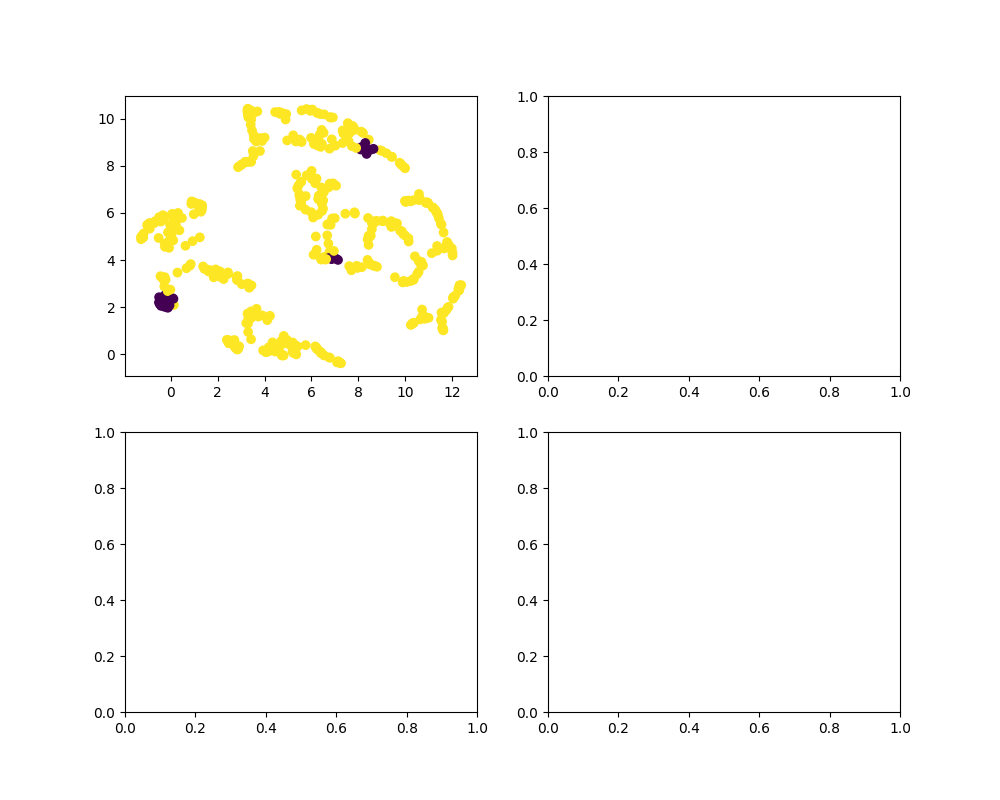

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'A': 0, 'B': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'A': 0, 'B': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,11.441441,11.441441,2.900901,4.838839,2.469469
1,14.564565,14.564565,3.605606,4.286286,2.583584
2,15.725726,12.502503,5.467467,3.473473,1.782783
3,26.576577,23.353353,2.392392,5.011011,1.590591
4,19.629630,22.852853,4.590591,5.943944,2.837838
...,...,...,...,...,...
495,12.842843,12.842843,5.535536,2.304304,2.393393
496,26.376376,28.758759,5.043043,2.416416,1.520521
497,11.521522,13.123123,4.266266,4.934935,2.515516
498,15.145145,15.145145,4.034034,3.205205,1.088088


In [16]:
met.explore(dr_method='umap')

In [17]:
met.data.user_labels = user_labels